In [1]:
%cd ..

c:\Code\Motor-Execution-Classifiaction


In [3]:
import pandas as pd
import numpy as np

import os

import mne
import numpy as np
import pandas as pd

from config.arms_offline import config

%matplotlib qt

In [4]:
subject = 'Erno'
session = 'session_08'

In [5]:
def loadData(subject, session, tmin=5):
    """
    Load the numpy session
    and convert it to mne dataset
    """
    path = os.path.join(config.data_path, subject, session, "data.npy")
    test = np.load(path)
    EEG = test[2:]
    EEG.shape
    EEG /= 1000 * 1000  # (µV->V) #for Unicorn
    test[2:] = EEG

    sfreq = 250

    ch_names = [
        "STIM",
        "Fz",
        "C3",
        "Cz",
        "C4",
        "Pz",
        "PO7",
        "Oz",
        "PO8",
    ]  # documentation
    # ch_names = ["STIM", "Fp1", "FC1", "FC2", "FCz", "CPz", "CP1", "CP2", "Pz"] # API

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq)

    raw = mne.io.RawArray(test[1:10], info)  # Drop timestamp channel

    raw.crop(tmin=tmin)

    for ch in info.ch_names:
        if ch == "STIM":
            raw.set_channel_types({ch: "stim"})
        else:
            raw.set_channel_types({ch: "eeg"})
    raw.set_montage("standard_1020")

    raw.describe()

    return raw


def filter(data):
    if config.bandpass:
        data = data.filter(
            config.bandpass_freq[0], config.bandpass_freq[1], fir_design="firwin"
        )
    if config.notch:
        data = data.notch_filter(config.notch_freq)


def create_epochs(data):
    event_dict = {"Rest": 1, "Left": 2, "Right": 3}  # ,'EndOfEvent': 10}
    mapping = {1: "Rest", 2: "Left", 3: "Right"}  # , 10:'EndOfEvent'}
    events = mne.find_events(data, stim_channel="STIM")
    annot_from_events = mne.annotations_from_events(
        events=events, event_desc=mapping, sfreq=data.info["sfreq"]
    )
    data.set_annotations(annot_from_events)
    data.drop_channels(["STIM"])
    return mne.Epochs(
        data, events, tmin=-0.3, tmax=2.0, event_id=event_dict, preload=True
    )


In [6]:
raw_data = loadData(subject, session, config.relax_time)
raw_data.describe()

Creating RawArray with float64 data, n_channels=9, n_times=112350
    Range : 0 ... 112349 =      0.000 ...   449.396 secs
Ready.


C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) Fz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) C3 has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) Cz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) C4 has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) Pz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:38: RuntimeWarning: The unit for channel(s) PO7 has changed from N

<RawArray | 9 x 109850 (439.4 s), ~7.6 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  STIM  STIM  NA         0.00       0.00       0.00       0.00      10.00
 1  Fz    EEG   µV    116172.12  116611.02  116686.57  116801.10  116991.18
 2  C3    EEG   µV    121772.22  122161.77  122223.46  122362.04  122571.61
 3  Cz    EEG   µV    129036.54  129132.38  129189.87  129461.22  130498.70
 4  C4    EEG   µV    111434.62  111939.15  112583.77  113610.08  116623.90
 5  Pz    EEG   µV    121096.75  121522.59  121588.66  121679.41  121863.41
 6  PO7   EEG   µV    103426.45  104020.46  104141.97  104408.92  104685.74
 7  Oz    EEG   µV    112706.53  112845.38  112870.05  112898.04  113094.38
 8  PO8   EEG   µV    144128.44  144635.28  144699.48  144770.38  144909.41
<RawArray | 9 x 109850 (439.4 s), ~7.6 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  STIM  STIM  NA         0.00       0.00       0.0

In [8]:
filtered_data = raw_data.copy()
filter(filtered_data)
filtered_data.describe()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 413 samples (1.652 sec)

<RawArray | 9 x 109850 (439.4 s), ~7.6 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  STIM  STIM  NA         0.00       0.00       0.00       0.00      10.00
 1  Fz    EEG   µV       -41.41      -3.03      -0.02       3.01      72.34
 2  C3    EEG   µV       -64.73      -3.81       0.02       3.83      64.52
 3  Cz    EEG   µV       -48.78      -3.92       0.03       3.94      63.23
 4

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [9]:
raw_motor_data = raw_data.copy()
raw_motor_data.drop_channels(["Fz", "Cz", "Pz", "PO7", "Oz", "PO8"])


<RawArray | 3 x 109850 (439.4 s), ~2.5 MB, data loaded>

In [12]:
filtered_motor_data = filtered_data.copy()
filtered_motor_data.drop_channels(["Fz", "Cz", "Pz", "PO7", "Oz", "PO8"])

<RawArray | 3 x 109850 (439.4 s), ~2.5 MB, data loaded>

Setting up band-pass filter from 8 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 13.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


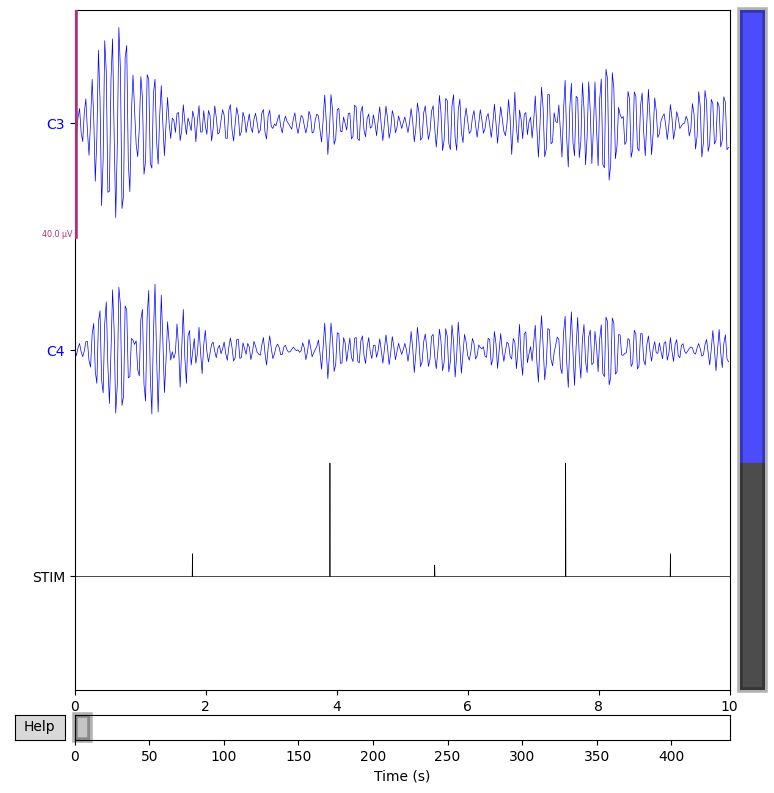

Channels marked as bad:
none


In [10]:
mne.viz.plot_raw(
    raw_motor_data, color=dict(eeg='b'),remove_dc=True, show_options=True, highpass=8.0, lowpass=13.0
)


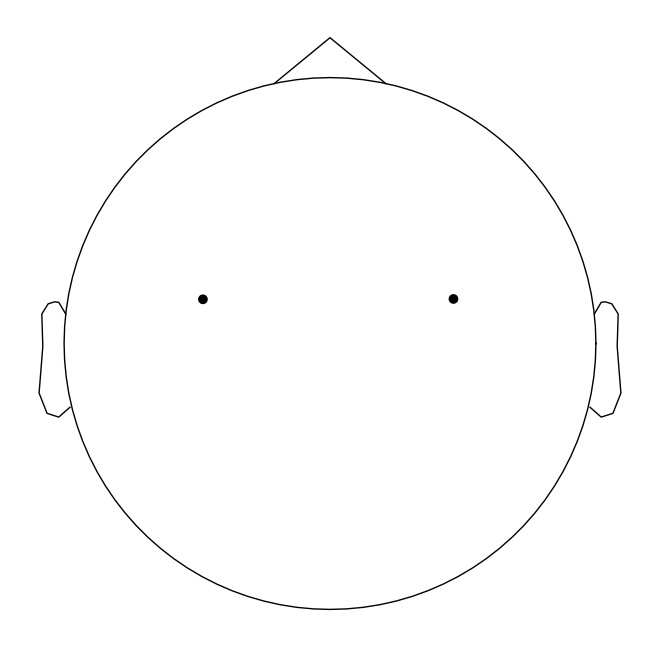

In [11]:
raw_motor_data.plot_sensors()

In [13]:
epochs = create_epochs(filtered_motor_data)

240 events found
Event IDs: [ 1  2  3 10]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 576 original time points ...
0 bad epochs dropped


C:\Users\Nemes\AppData\Local\Temp\ipykernel_18752\3746520840.py:62: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  data.set_annotations(annot_from_events)


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


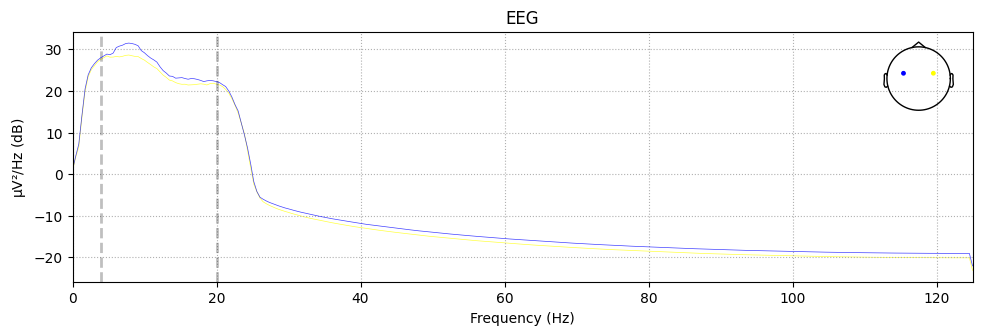

In [14]:
epochs['Left'].compute_psd().plot(picks='eeg')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


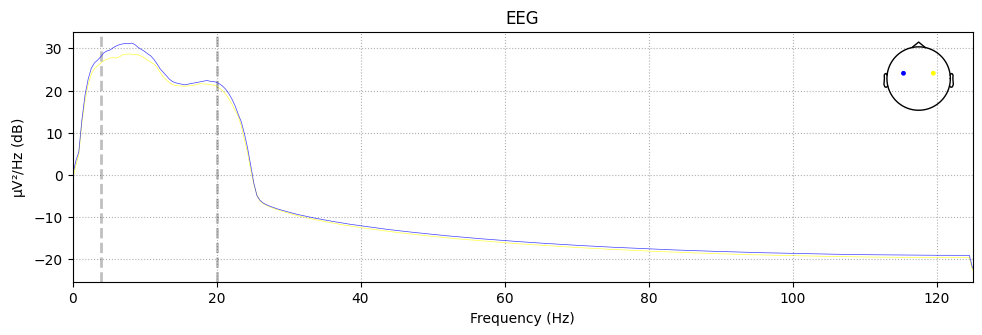

In [15]:
epochs['Right'].compute_psd().plot(picks='eeg')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


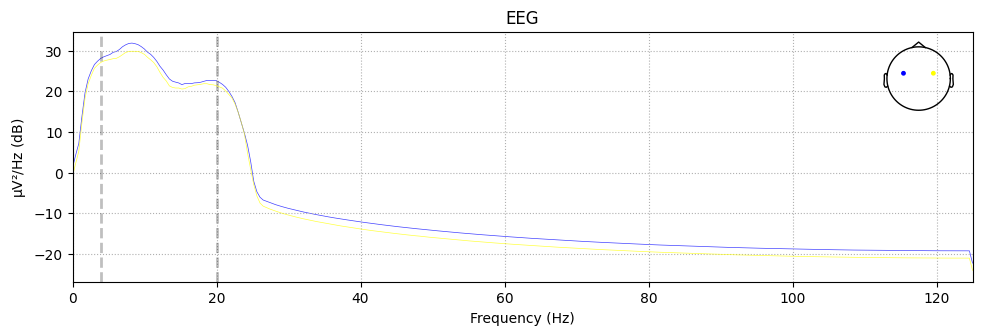

In [16]:
epochs['Rest'].compute_psd().plot(picks='eeg')

In [17]:
epochs['Left'].plot_image()

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [18]:
epochs['Right'].plot_image()

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [19]:
epochs['Rest'].plot_image()

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [20]:
right_evoked = epochs['Right'].average()
left_evoked = epochs['Left'].average()
rest_evoked = epochs['Rest'].average()

mne.viz.plot_compare_evokeds(dict(left=left_evoked, right=right_evoked, rest=rest_evoked),
                             legend='upper left', show_sensors='upper right')


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 2 Axes>]

No projector specified for this dataset. Please consider the method self.add_proj.


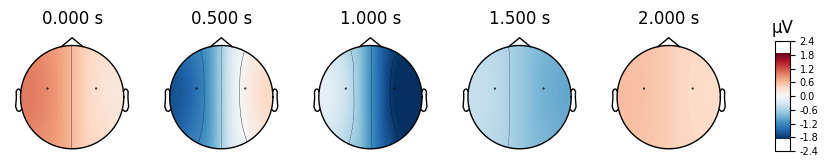

In [22]:
right_evoked.plot_joint(picks='eeg')
right_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


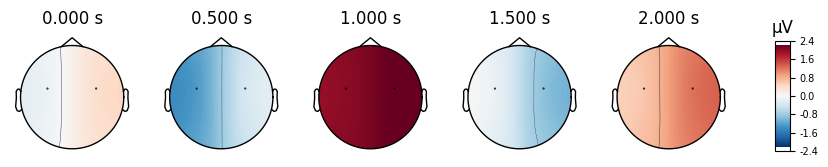

In [23]:
left_evoked.plot_joint(picks='eeg')
left_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


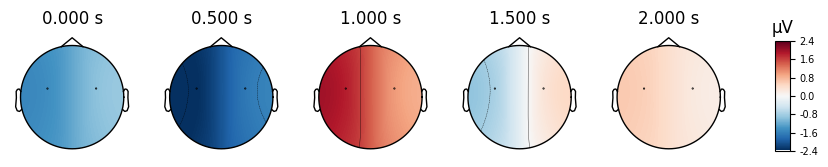

In [24]:
rest_evoked.plot_joint(picks='eeg')
rest_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')